In [0]:
!pip install -q kmodes

In [0]:
#!pip install pycodestyle

In [0]:
#!pip install pycodestyle_magic

In [0]:
#!pip install flake8

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import QuantileTransformer, quantile_transform

from kmodes.kmodes import KModes
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram

In [0]:
#%load_ext pycodestyle_magic

In [0]:
#%pycodestyle_on

In [0]:
pd.set_option('display.max_colwidth', -1)

In [0]:
customers_data = pd.read_csv("P4/olist_customers_dataset.csv")
orders_data = pd.read_csv("P4/olist_orders_dataset.csv")
order_items_data = pd.read_csv("P4/olist_order_items_dataset.csv")
products_data = pd.read_csv("P4/olist_products_dataset.csv")

In [0]:
order_review_data = pd.read_csv("P4/olist_order_reviews_dataset.csv")

In [0]:
name_translation_data = pd.read_csv("P4/product_category_name_translation.csv")

In [32]:
customers_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [33]:
customers_data.shape

(99441, 5)

In [34]:
customers_data.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [35]:
orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [36]:
orders_data.shape

(99441, 8)

In [0]:
orders_data.drop(["order_delivered_carrier_date",
                  "order_delivered_customer_date",
                  "order_estimated_delivery_date",
                  "order_status"], axis=1, inplace=True)

In [38]:
orders_data["order_approved_at"].isna().sum()

160

In [0]:
orders_data = orders_data[~orders_data["order_approved_at"].isna()]

In [40]:
orders_data.isna().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
order_approved_at           0
dtype: int64

In [41]:
orders_data.shape

(99281, 4)

In [42]:
orders_data.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29


In [0]:
# Orders and customers dataset merged
result = pd.merge(customers_data, orders_data, on='customer_id')

In [44]:
result.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_id                    0
order_purchase_timestamp    0
order_approved_at           0
dtype: int64

In [45]:
result.shape

(99281, 8)

In [46]:
result.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07-29 10:10:09


In [47]:
order_items_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [48]:
order_items_data["order_id"].value_counts()  # Number items paid by customer

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
dff79b743bbac91445b8b167b6ae9da5     1
7f8c45241719d873d8f5e3899b7101be     1
3fc92f79759d64684c5d19448a12642f     1
9e98bdb07065bc0ef966530ecdc91ec9     1
0009792311464db532ff765bf7b182ae     1
Name: order_id, Length: 98666, dtype: int64

In [49]:
order_items_data.shape

(112650, 7)

In [0]:
order_items_data.drop(["seller_id", "shipping_limit_date",
                       "freight_value"], axis=1, inplace=True)

In [51]:
order_items_data.isna().sum()

order_id         0
order_item_id    0
product_id       0
price            0
dtype: int64

In [0]:
# Orders, customers and orders_items dataset merged
result2 = pd.merge(result, order_items_data, on='order_id')

In [53]:
result2.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_id                    0
order_purchase_timestamp    0
order_approved_at           0
order_item_id               0
product_id                  0
price                       0
dtype: int64

In [54]:
result2.shape

(112635, 11)

In [55]:
products_data.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [56]:
products_data["product_id"].unique().shape[0]

32951

In [57]:
products_data.shape

(32951, 9)

In [0]:
products_data.drop(["product_name_lenght", "product_description_lenght",
                    "product_photos_qty", "product_weight_g", 
                    "product_length_cm", "product_height_cm", "product_width_cm"],
                    axis=1, inplace=True)

In [59]:
products_data["product_category_name"].isna().sum()

610

In [0]:
products_data = products_data[~products_data["product_category_name"].isna()]

In [0]:
name_dict = {}
for i, row in name_translation_data.iterrows():
    name_dict[row["product_category_name"]] = row["product_category_name_english"]

In [0]:
liste_name_trans = list(name_translation_data["product_category_name"].values)

In [0]:
for i, row in products_data.iterrows():
    if row["product_category_name"] in liste_name_trans:
        products_data.loc[i,"product_category_name"] = name_dict[row["product_category_name"]]

In [64]:
products_data["product_category_name"]

0                        perfumery
1                              art
2                   sports_leisure
3                             baby
4                       housewares
                   ...            
32946              furniture_decor
32947    construction_tools_lights
32948               bed_bath_table
32949        computers_accessories
32950               bed_bath_table
Name: product_category_name, Length: 32341, dtype: object

In [0]:
# Orders, customers, orders_items and products dataset merged
result3 = pd.merge(result2, products_data, on='product_id')

In [66]:
order_review_data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [67]:
order_review_data.shape

(100000, 7)

In [68]:
order_review_data.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [0]:
order_review_data.drop(["review_comment_title", "review_comment_message",
                        "review_creation_date", "review_answer_timestamp"],
                       axis=1, inplace=True)

In [70]:
order_review_data.head()

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [0]:
donnees = pd.merge(result3, order_review_data, on='order_id')

In [74]:
donnees[['customer_unique_id', 'customer_state', 'order_purchase_timestamp', 'price',	'product_category_name', 'review_score']].head()  # Rows of each article paid

,customer_unique_id,customer_state,order_purchase_timestamp,price,product_category_name,review_score
0,861eff4711a542e4b93843c6dd7febb0,SP,2017-05-16 15:05:35,124.99,office_furniture,4
1,9eae34bbd3a474ec5d07949ca7de67c0,PA,2017-11-09 00:50:13,112.99,office_furniture,1
2,9eae34bbd3a474ec5d07949ca7de67c0,PA,2017-11-09 00:50:13,112.99,office_furniture,1
3,3c799d181c34d51f6d44bbbc563024db,RS,2017-05-07 20:11:26,124.99,office_furniture,3
4,23397e992b09769faf5e66f9e171a241,RJ,2018-02-03 19:45:40,106.99,office_furniture,4


In [72]:
donnees.shape

(111696, 14)

In [64]:
donnees.dtypes

customer_id                 object 
customer_unique_id          object 
customer_zip_code_prefix    int64  
customer_city               object 
customer_state              object 
order_id                    object 
order_purchase_timestamp    object 
order_approved_at           object 
order_item_id               int64  
product_id                  object 
price                       float64
product_category_name       object 
review_id                   object 
review_score                int64  
dtype: object

In [65]:
len(donnees["customer_unique_id"].unique())

94096

In [0]:
# dummies = pd.get_dummies(donnees["product_category_name"])
# dummies.columns = ["product_category_name"+str(s) for s in dummies.columns]
# df.drop(colname,inplace=True, axis=1)
# df = pd.concat([df, dummies], axis=1)
# dummies

# RFM

In [67]:
# Distribution of customers by city of Brazil
distribution = donnees[['customer_city', 'customer_unique_id']].\
                groupby(['customer_city']).\
                agg({'customer_unique_id': lambda x: x.nunique()}).\
                reset_index().sort_values('customer_unique_id',
                                          ascending=False)

distribution.rename(columns={'customer_unique_id': 'nombre clients'},
                    inplace=True)
distribution.head()

,customer_city,nombre clients
3576,sao paulo,14636
3136,rio de janeiro,6471
451,belo horizonte,2609
556,brasilia,2027
1139,curitiba,1440


In [68]:
distribution['nombre clients'].sum()

94215

In [69]:
# Verify if all the price are positive
donnees.price.min()

0.85

In [70]:
def unique_counts(df):
    """ Returns the unique number of value per variable. """
    for i in df.columns:
        count = df[i].nunique()
        print("%s : %d" % (i, count))


unique_counts(donnees)

customer_id : 97264
customer_unique_id : 94096
customer_zip_code_prefix : 14927
customer_city : 4095
customer_state : 27
order_id : 97264
order_purchase_timestamp : 96729
order_approved_at : 88976
order_item_id : 21
product_id : 32338
price : 5902
product_category_name : 73
review_id : 97062
review_score : 5


In [71]:
# Search for the earliest date
ancien = donnees["order_purchase_timestamp"].min()
ancien

'2016-09-04 21:15:19'

In [72]:
# search for the most recent date
recent = donnees["order_purchase_timestamp"].max()
recent

'2018-09-03 09:06:57'

In [0]:
import datetime as dt
aammjj = str.split(str.split(recent)[0], "-")
NOW = dt.datetime(int(aammjj[0]), int(aammjj[1]), int(aammjj[2]) + 1)

In [0]:
# Type of "order_purchase_timestamp" to datetime
donnees["order_purchase_timestamp"] = pd.\
    to_datetime(donnees["order_purchase_timestamp"])

In [0]:
# Set up the RFM table
#
# Recency: number of days elapsed since last purchase
#
# Frequency: the number of times the customer has made a purchase
#
# Monetary: the total amount spent by a client
rfmTable = donnees.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: (NOW - x.max()).days,
                 "order_id": lambda x: x.nunique(),
                 "price": lambda x: sum(x)})

rfmTable['order_purchase_timestamp'] = rfmTable['order_purchase_timestamp'].astype(int)
rfmTable.rename(columns={'order_purchase_timestamp': 'recency',
                         'order_id': 'frequency',
                         'price': 'monetary_value'}, inplace=True)

In [76]:
rfmTable.head()

,recency,frequency,monetary_value
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
0000f46a3911fa3c0805444483337064,541,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
0004aac84e0df4da2b147fca70cf8255,292,1,180.00


In [77]:
rfmTable.columns

Index(['recency', 'frequency', 'monetary_value'], dtype='object')

In [78]:
rfmTable.shape

(94096, 3)

In [79]:
quartiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])  # Quartile
print(quartiles)

      recency  frequency  monetary_value
0.25  118.0    1.0        47.90         
0.50  222.0    1.0        89.90         
0.75  351.0    1.0        156.45        


In [80]:
quartiles = quartiles.to_dict()    # Trsnformation dataframe to dictionary
quartiles

{'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary_value': {0.25: 47.9, 0.5: 89.9, 0.75: 156.45},
 'recency': {0.25: 118.0, 0.5: 222.0, 0.75: 351.0}}

In [0]:
segmented_rfm = rfmTable.copy()

In [0]:
def RScore(x, p, d):
    """Returns the recent score for a value relative to quartile value"""
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


def FMScore(x, p, d):
    """
        Returns the frequency and monetary score
        to quartile value
    """
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [83]:
# Table RFM with score
segmented_rfm['r_quartile'] = segmented_rfm['recency'].\
    apply(RScore, args=('recency', quartiles))

segmented_rfm['f_quartile'] = segmented_rfm['frequency'].\
    apply(FMScore, args=('frequency', quartiles))

segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].\
    apply(FMScore, args=('monetary_value', quartiles))

segmented_rfm['RFMScore'] = (segmented_rfm["r_quartile"].astype(str) + "-").\
                    str.cat(segmented_rfm["f_quartile"].astype(str) + "-").\
                    str.cat(segmented_rfm["m_quartile"].astype(str))

segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,1,4,2,1-4-2
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,1,4,4,1-4-4
0000f46a3911fa3c0805444483337064,541,1,69.00,4,4,3,4-4-3
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,3,4,4,3-4-4
0004aac84e0df4da2b147fca70cf8255,292,1,180.00,3,4,1,3-4-1


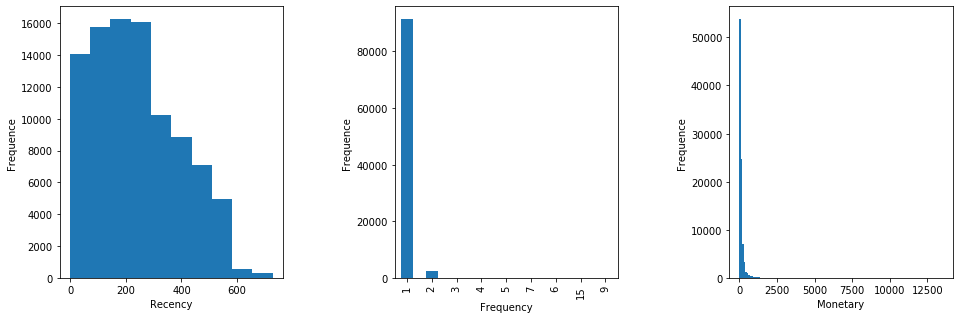

In [84]:
def compute_histogram_bins(data, desired_bin_size):
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int((max_boundary - min_boundary) / desired_bin_size) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins


r = segmented_rfm['recency']
m = segmented_rfm['monetary_value']

plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace=0.5)

# Recency
plt.subplot(131)
plt.xlabel('Recency')
plt.ylabel('Frequence')
counts, bins = np.histogram(r)
plt.hist(bins[:-1], bins, weights=counts)

# Frequency
plt.subplot(132)
plt.xlabel('Frequency')
plt.ylabel('Frequence')
segmented_rfm['frequency'].value_counts().plot(kind="bar", width=0.5)

# Monetary
plt.subplot(133)
plt.xlabel('Monetary')
plt.ylabel('Frequence')
bins = compute_histogram_bins(m, 100)
plt.hist(m, bins=bins)

plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f2a00cd6ba8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2a00ce3438>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2a00ce3e10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2a00ce3ac8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2a00cd6cf8>,
  <matplotlib.lines.Line2D at 0x7f2a00ce30f0>]}

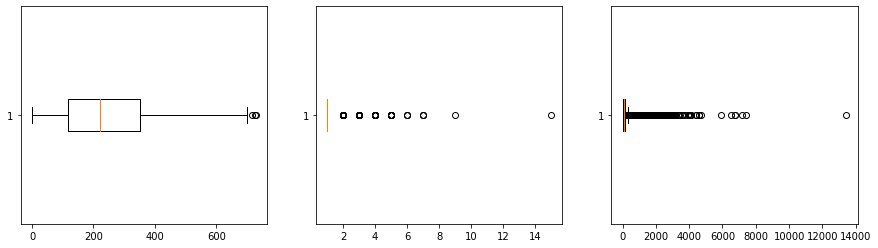

In [85]:
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.boxplot(segmented_rfm["recency"], vert=False)

ax = fig.add_subplot(132)
ax.boxplot(segmented_rfm["frequency"], vert=False)

ax = fig.add_subplot(133)
ax.boxplot(segmented_rfm["monetary_value"], vert=False)

In [86]:
segmented_rfm['RFMScore'].unique()

array(['1-4-2', '1-4-4', '4-4-3', '3-4-4', '3-4-1', '2-4-2', '2-4-4',
       '2-4-1', '4-4-2', '4-4-4', '3-4-3', '2-4-3', '4-4-1', '1-4-3',
       '1-4-1', '3-4-2', '3-1-1', '1-1-3', '2-1-2', '4-1-1', '2-1-1',
       '1-1-1', '2-1-4', '4-1-3', '3-1-2', '1-1-2', '3-1-3', '1-1-4',
       '2-1-3', '4-1-4', '4-1-2', '3-1-4'], dtype=object)

In [87]:
mean_var = segmented_rfm.groupby("RFMScore")[
    ["recency", "frequency", "monetary_value"]].\
    agg([np.mean, np.var])

mean_var["size"] = segmented_rfm.groupby('RFMScore')[['recency']].\
    agg([np.size])

mean_var

recency              frequency  ... monetary_value                 size
                mean          var      mean  ...           mean            var      
RFMScore                                     ...                                    
1-1-1     63.043564   1110.275876  2.227723  ...  390.359465     121609.041936  505 
1-1-2     60.455556   1070.361142  2.038889  ...  120.796722     315.336591     180 
1-1-3     65.563830   1097.237817  2.042553  ...  70.661277      133.666044     94  
1-1-4     59.480000   1393.010000  2.000000  ...  36.312400      67.821627      25  
1-4-1     62.515836   1101.882252  1.000000  ...  368.460493     147849.568726  5399
1-4-2     62.639231   1112.854918  1.000000  ...  119.526550     342.967106     5771
1-4-3     59.711919   1126.555595  1.000000  ...  66.520719      153.907348     5856
1-4-4     60.690692   1119.372805  1.000000  ...  29.311692      105.664329     5952
2-1-1     173.532520  892.827861   2.168699  ...  365.225366     71585.021583   492 
2-1-2     169.921687  920.436254   2.066265  ...  122.347169     338.164315     166 
2-1-3     171.414634  1005.801265  2.012195  ...  71.559268      145.508901     82  
2-1-4     167.240000  848.190000   2.000000  ...  33.818400      77.129797      25  
2-4-1     168.993258  895.427563   1.000000  ...  348.085051     94695.994773   5340
2-4-2     168.895908  924.475611   1.000000  ...  120.623489     363.712377     5572
2-4-3     170.127868  902.610486   1.000000  ...  66.623783      166.794237     5709
2-4-4     171.772252  859.648847   1.000000  ...  29.464815      107.338941     5932
3-1-1     282.520642  1348.406469  2.107798  ...  405.153784     118779.265718  436 
3-1-2     280.892405  1305.230388  2.018987  ...  121.841139     349.068294     158 
3-1-3     285.536585  1064.498645  2.012195  ...  69.652317      169.145766     82  
3-1-4     290.411765  1323.382353  2.000000  ...  40.706471      53.363062      17  
3-4-1     282.405519  1253.354991  1.000000  ...  347.300715     120713.371720  5472
3-4-2     281.259093  1231.628940  1.000000  ...  119.656115     364.179411     5361
3-4-3     280.899701  1248.220962  1.000000  ...  66.829309      173.938000     6351
3-4-4     280.303377  1248.684200  1.000000  ...  29.089172      104.392903     5686
4-1-1     438.862573  4393.379885  2.081871  ...  416.046520     281979.244514  342 
4-1-2     442.700680  4344.457739  2.047619  ...  124.479796     342.965594     147 
4-1-3     458.272727  4305.647552  2.106061  ...  70.195303      146.509041     66  
4-1-4     483.187500  6883.899194  2.156250  ...  33.655000      69.538058      32  
4-4-1     459.122991  5465.397985  1.000000  ...  364.044593     128796.448766  5537
4-4-2     457.014057  5067.088317  1.000000  ...  118.421639     324.381888     5051
4-4-3     451.613838  4953.946659  1.000000  ...  66.945356      171.248104     6316
4-4-4     459.526254  5098.075645  1.000000  ...  28.942839      109.713155     5942

[32 rows x 7 columns]

In [0]:
# Contingency table
# Recency X frequency, Recency X Monetary_value, Frequency X Monetary_value
RF = pd.DataFrame(columns=['1', '2', '3', '4'])
RM = pd.DataFrame(columns=['1', '2', '3', '4'])
FM = pd.DataFrame(columns=['1', '2', '3', '4'])
size = segmented_rfm.shape[0]
for i in range(1, 5):
    row_crf = []
    row_crm = []
    row_cfm = []
    for j in range(1, 5):
        crf = 0
        crm = 0
        cfm = 0
        for k, row in segmented_rfm.iterrows():
            if row["r_quartile"] == i and row["f_quartile"] == j:
                crf += 1
            if row["r_quartile"] == i and row["m_quartile"] == j:
                crm += 1
            if row["f_quartile"] == i and row["m_quartile"] == j:
                cfm += 1
        row_crf.append(crf)
        row_crm.append(crm)
        row_cfm.append(cfm)
    RF.loc[i] = row_crf
    RM.loc[i] = row_crm
    FM.loc[i] = row_cfm

In [89]:
RF.style.set_caption("Recency X Frequency")
RF

,1,2,3,4
1,804,0,0,22978
2,765,0,0,22553
3,693,0,0,22870
4,587,0,0,22846


In [90]:
RM.style.set_caption("Recency X Monetary")
RM

,1,2,3,4
1,5904,5951,5950,5977
2,5832,5738,5791,5957
3,5908,5519,6433,5703
4,5879,5198,6382,5974


In [91]:
FM.style.set_caption("frequency X Monetary")
FM

,1,2,3,4
1,1775,651,324,99
2,0,0,0,0
3,0,0,0,0
4,21748,21755,24232,23512


In [0]:
customer_segment = pd.DataFrame()
segment = ["Best Customers", "Loyal Customers", "Big Spenders", "Almost Lost",
           "Lost Customers", "Lost Cheap Customers", "Autres"
          ]
rfm = ["1-1-1", "X-1-X", "X-X-1", "3-1-1", "4-1-1", "4-4-4", "Autres"]
description = ["Les clients qui ont acheté le plus récemment, le plus souvent \
               et qui dépensent le plus.",
               "Les clients ayant acheté le plus récemment",
               "Les clients qui dépensent le plus",
               "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
               et ont dépensé le plus.",
               "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont \
               dépensé le plus.",
               "Dernier achat il y a longtemps, acheté peu et dépensé peu.",
               ""
              ]
marketing = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
             "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
             "Commercialisez vos produits les plus chers.",
             "Offrez d'autres produits pertinents et des rabais spéciaux.",
             "Incitations à des prix agressifs",
             "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             "Ajuster les intervales pour le réduire si important"
            ]
customer_segment["rfm"] = rfm
customer_segment["segments clients"] = segment 

In [0]:
sums = []
X1X = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4"]
XX1 = ["1-2-1", "1-3-1", "1-4-1", "2-2-1", "2-3-1", "2-4-1"]
for r in rfm:
    count = 0
    if r == "X-1-X":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] in X1X:
                count += 1
        sums.append(count)
    if r == "X-X-1":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] in XX1 and r != "2-1-1":
                count += 1
        sums.append(count)
    if r != "X-1-X" and r != "X-X-1" and r != "Autres":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] == r:
                count += 1
        sums.append(count)
    if r == "Autres":
        for j, row in segmented_rfm.iterrows():
            if row["RFMScore"] not in rfm and row["RFMScore"] not in X1X and \
            row["RFMScore"] not in XX1:
                count += 1
        sums.append(count)
        
customer_segment["nombre de clients"] = sums

In [94]:
customer_segment["activité"] = description
customer_segment["Conseil d'action"] = marketing

# Customer/segment
customer_segment

,rfm,segments clients,nombre de clients,activité,Conseil d'action
0,1-1-1,Best Customers,505,"Les clients qui ont acheté le plus récemment, le plus souvent et qui dépensent le plus.","Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité"
1,X-1-X,Loyal Customers,1064,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.
2,X-X-1,Big Spenders,10739,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
3,3-1-1,Almost Lost,436,"N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment et ont dépensé le plus.",Offrez d'autres produits pertinents et des rabais spéciaux.
4,4-1-1,Lost Customers,342,"N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont dépensé le plus.",Incitations à des prix agressifs
5,4-4-4,Lost Cheap Customers,5942,"Dernier achat il y a longtemps, acheté peu et dépensé peu.",Ne passez pas trop de temps à essayer de vous ré-acquérir.
6,Autres,Autres,75068,,Ajuster les intervales pour le réduire si important


In [0]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers", "Autres"
           ]
description_ = ["Les clients qui ont acheté le plus récemment, le plus souvent \
                et qui dépensent le plus.",
                "Les clients ayant acheté le plus récemment",
                "Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",
                "Les clients qui dépensent le plus",
                "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "Dernier achat il y a longtemps, acheté peu et dépensé peu.",
                ""
               ]
marketing_ = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
              "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
              "offrir des essais gratuits",
              "Commercialisez vos produits les plus chers.",
              "Offrez d'autres produits pertinents et des rabais spéciaux.",
              "Incitations à des prix agressifs",
              "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
              "Ajuster les intervales pour le réduire si important"
             ]
customer_segment_["segment"] = segment_

In [0]:
recents_ = []
def countCustomerSegment(segmented_rfmp):
    """Main function is to return the customer identities for each segment"""
    seg_cus_id = {"Best Customers": [], "Loyal Customers": [], "Promissing": [],
                  "Big Spenders": [],"Almost Lost": [], "Lost Customers": [],
                  "Lost Cheap Customers": [], "Autres": []}
    sums_ = []
    best = ["1-1-1"]
    X1X_ = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4", "1-4-2", "2-4-2"]
    promiss = ["1-4-3", "1-4-4", "2-4-3", "2-4-4"]
    XX1_ = ["1-2-1", "1-3-1", "1-4-1", "2-3-1", "2-4-1"]
    almost_lost = ["3-1-1", "3-4-1", "3-4-2"]
    lost = ["3-4-3", "3-4-4", "4-1-1", "4-4-1", "4-4-2"]
    lost_cheap = ["4-4-4", "4-4-3"]
    for s in segment_:
        count = 0
        rec = 0
        if s == "Best Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in best:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Loyal Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in X1X_:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Promissing":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in promiss:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Big Spenders":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in XX1_:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Almost Lost":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in almost_lost:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Lost Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in lost:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Lost Cheap Customers":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] in lost_cheap:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
        if s == "Autres":
            for j, row in segmented_rfmp.iterrows():
                if row["RFMScore"] not in best and row["RFMScore"] not in X1X_ \
                and row["RFMScore"] not in XX1_ and row["RFMScore"] not in promiss and \
                row["RFMScore"] not in lost and row["RFMScore"] not in almost_lost and \
                row["RFMScore"] not in lost_cheap:
                    count += 1
                    rec += row["recency"]
                    seg_cus_id[s].append(j)
                    
        sums_.append(count)
        recents_.append(int(rec/count))
        
    return (seg_cus_id,sums_)

In [97]:
cus_id, customer_segment_["nombre de clients"] = countCustomerSegment(segmented_rfm)
customer_segment_["description"] = description_
customer_segment_["marketing"] = marketing_

#customer/segment
customer_segment_

,segment,nombre de clients,description,marketing
0,Best Customers,505,"Les clients qui ont acheté le plus récemment, le plus souvent et qui dépensent le plus.","Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité"
1,Loyal Customers,12407,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.
2,Promissing,23449,"Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",offrir des essais gratuits
3,Big Spenders,10739,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
4,Almost Lost,11269,"N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment et ont dépensé le plus.",Offrez d'autres produits pertinents et des rabais spéciaux.
5,Lost Customers,22967,"N'ont pas acheté depuis longtemps, mais ont acheté fréquemment et ont dépensé le plus.",Incitations à des prix agressifs
6,Lost Cheap Customers,12258,"Dernier achat il y a longtemps, acheté peu et dépensé peu.",Ne passez pas trop de temps à essayer de vous ré-acquérir.
7,Autres,502,,Ajuster les intervales pour le réduire si important


Text(0, 0.5, 'Nombre de clients par segments')

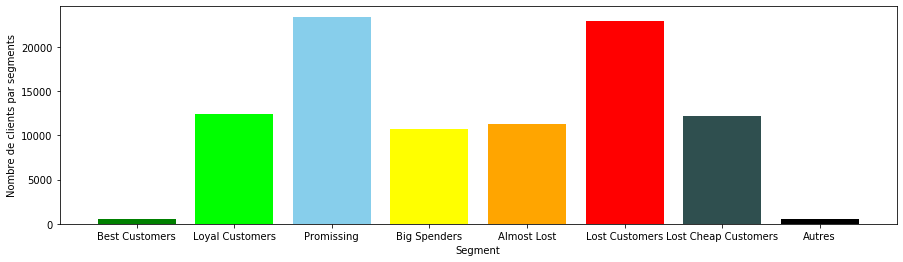

In [98]:
plt.figure(figsize=(15, 4))
plt.bar(customer_segment_["segment"], customer_segment_["nombre de clients"], align='center',
        color=["green", "lime", "#87ceeb", "yellow", "orange", "red", "#2F4F4F", "black"]
       )
plt.xlabel('Segment')
plt.ylabel('Nombre de clients par segments')

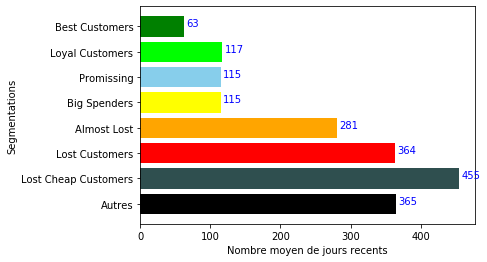

In [99]:
fig, ax = plt.subplots() 
ax.barh(customer_segment_["segment"].iloc[::-1] , recents_[::-1],
        color=["black", "#2F4F4F", "red", "orange", "yellow","#87ceeb", "lime", "green"]
       )
plt.xlabel('Nombre moyen de jours recents')
plt.ylabel('Segmentations')
for i, v in enumerate(recents_[::-1]):
    ax.text(v + 3, i + .0, str(v), color='blue')

In [0]:
XRFM = segmented_rfm[["recency", "frequency", "monetary_value"]].copy()
segments_labels = []
for i, row in XRFM.iterrows():
    if i in cus_id["Best Customers"]:
        segments_labels.append("Best Customers")
        continue
    if i in cus_id["Loyal Customers"]:
        segments_labels.append("Loyal Customers")
        continue
    if i in cus_id["Promissing"]:
        segments_labels.append("Promissing")
        continue
    if i in cus_id["Big Spenders"]:
        segments_labels.append("Big Spenders")
        continue
    if i in cus_id["Almost Lost"]:
        segments_labels.append("Almost Lost")
        continue
    if i in cus_id["Lost Customers"]:
        segments_labels.append("Lost Customers")
        continue
    if i in cus_id["Lost Cheap Customers"]:
        segments_labels.append("Lost Cheap Customers")
        continue
    if i in cus_id["Autres"]:
        segments_labels.append("Autres")
        continue

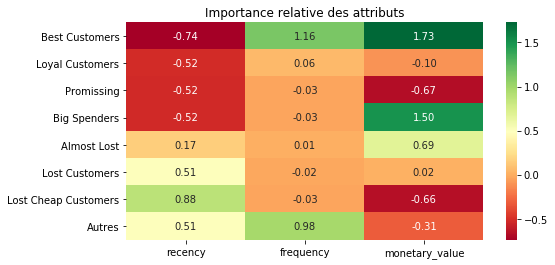

In [101]:
relative_imp_sort = pd.DataFrame()
XRFM["segment_appartenance"] = segments_labels

population = segmented_rfm[["recency", "frequency", "monetary_value"]].copy()
population_avg = population.mean()

cluster_avg = XRFM.groupby(['segment_appartenance']).mean()
relative_imp = cluster_avg / population_avg - 1

relative_imp_sort["Best Customers"] = relative_imp.loc["Best Customers"]
relative_imp_sort["Loyal Customers"] = relative_imp.loc["Loyal Customers"]
relative_imp_sort["Promissing"] = relative_imp.loc["Promissing"]
relative_imp_sort["Big Spenders"] = relative_imp.loc["Big Spenders"]
relative_imp_sort["Almost Lost"] = relative_imp.loc["Almost Lost"]
relative_imp_sort["Lost Customers"] = relative_imp.loc["Lost Customers"]
relative_imp_sort["Lost Cheap Customers"] = relative_imp.loc["Lost Cheap Customers"]
relative_imp_sort["Autres"] = relative_imp.loc["Autres"]

plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp_sort.T, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

In [0]:
# Maintenance

In [103]:
# Retrieve the last three months
past = {}
for i in range(0, 4):
    past[i] = dt.datetime(int(aammjj[0]), int(aammjj[1])-i, int(aammjj[2]))
past

{0: datetime.datetime(2018, 9, 3, 0, 0),
 1: datetime.datetime(2018, 8, 3, 0, 0),
 2: datetime.datetime(2018, 7, 3, 0, 0),
 3: datetime.datetime(2018, 6, 3, 0, 0)}

In [0]:
customerPast = donnees[donnees["order_purchase_timestamp"] < past[3]]
customer_retain = customerPast["customer_unique_id"].unique()

In [105]:
dist = {}
cus_id_list = {}
dict_rfmTable = {}
for i in range(0, 4):
    customerPast = donnees[donnees["order_purchase_timestamp"] < past[i]]
    customerPast = customerPast[customerPast["customer_unique_id"].isin(list(customer_retain))]
    rfmTablePast = customerPast.groupby('customer_unique_id').\
                    agg({"order_purchase_timestamp": lambda x: (past[i] - x.max()).days,
                         "price": lambda x: sum(x)})

    rfmTablePast['order_purchase_timestamp'] = rfmTablePast['order_purchase_timestamp'].astype(int)
    rfmTablePast.rename(columns={'order_purchase_timestamp': 'recency',
                                 'price': 'monetary_value'
                                }, inplace=True)
    
    '''
    Calcul of number of orders by customer
    '''
    dd = customerPast.groupby(['customer_unique_id', 'order_id']).\
                   agg({"customer_unique_id": lambda x: 0})

    freq = []
    for index in list(rfmTablePast.index):
        freq.append(dd.loc[[index]].shape[0])
    
    rfmTablePast['frequency'] = freq

    cols = ['recency', 'frequency', 'monetary_value'] 
    rfmTablePast = rfmTablePast[cols]
    
    
    quartilesPast = rfmTablePast.quantile(q=[0.25, 0.5, 0.75])
    quartilesPast = quartilesPast.to_dict()  # Transformation dataframe en dictionnaire

    rfmTablePast['r_quartile'] = rfmTablePast['recency'].\
        apply(RScore, args=('recency', quartilesPast))
    rfmTablePast['f_quartile'] = rfmTablePast['frequency'].\
        apply(FMScore, args=('frequency', quartilesPast))
    rfmTablePast['m_quartile'] = rfmTablePast['monetary_value']. \
        apply(FMScore, args=('monetary_value', quartilesPast))

    rfmTablePast['RFMScore'] = (rfmTablePast["r_quartile"].astype(str) + "-").\
                                str.cat(rfmTablePast["f_quartile"].astype(str) + "-").\
                                str.cat(rfmTablePast["m_quartile"].astype(str))
    
    cus_id_list[i], dist[i] = countCustomerSegment(rfmTablePast)
    dict_rfmTable[i] = rfmTablePast.copy()
dist

{0: [623, 10187, 18917, 8487, 9055, 18652, 9926, 416],
 1: [563, 10054, 18945, 8603, 9070, 18671, 9940, 417],
 2: [495, 10078, 19120, 8686, 8991, 18575, 9904, 414],
 3: [382, 10042, 19178, 8712, 9007, 18612, 9915, 415]}

In [0]:
# Construct matching indices between source and target
s = []
t = []
for i in range(0, 24):
    for j in range(0, 8):
        s.append(i)
    if i in range(0, 8):
        for k in range(8, 16):
            t.append(k)
    if i in range(8, 16):
        for k in range(16, 24):
            t.append(k)
    if i in range(16, 24):
        for k in range(24, 32):
            t.append(k)

In [0]:
# Construct the values between the sources and the targets
v = []
m_v = {}
for i in range(3, 0, -1):
    m = []
    for j in range(0, 8):
        line = []
        for k in range(0, 8):
            nb_int = len(set(cus_id_list[i][segment_[j]]) &
                         set(cus_id_list[i-1][segment_[k]]))
            v.append(nb_int)
            line.append(nb_int)
        m.append(line)
    m_v[i] = m

In [0]:
# Set up labels and colors
ls = []
c = []
labels_set = ["Best Customers", "Loyal Customers", "Promissing",
              "Big Spenders", "Almost Lost", "Lost Customers",
              "Lost Cheap Customers", "Autres"]
colors_set = ["green", "lime", "#87ceeb", "yellow", "orange",
              "red", "#2F4F4F", "black"]

for i in range(1, 5):
    for j in range(0, 8):
        ls.append(labels_set[j] + str(i))
        c.append(colors_set[j])

In [109]:
# Display Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20,
                line=dict(color ="black", width=0.5),
                label=ls, color = c
               ),
    link=dict(source=s, target=t, value=v)
    )])

fig.update_layout(title_text="Diagramme de flux de clients entre segments",
                  font_size=10)
fig.show()

In [110]:
values1 = pd.DataFrame(m_v[3])  # (2018, 6, 3, 0, 0) to (2018, 7, 3, 0, 0)
values1 = values1.rename(index={0: "Best Customers (2018, 6, 3)",
                                1: "Loyal Customers (2018, 6, 3)",
                                2: "Promissing (2018, 6, 3)",
                                3: "Big Spenders (2018, 6, 3)",
                                4: "Almost Lost (2018, 6, 3)",
                                5: "Lost Customers (2018, 6, 3)",
                                6: "Lost Cheap (2018, 6, 3)",
                                7: "Autres (2018, 6, 3)"
                               },
                         columns={0: "Best Customers (2018, 7, 3)",
                                  1: "Loyal Customers (2018, 7, 3)",
                                  2: "Promissing (2018, 7, 3)",
                                  3: "Big Spenders (2018, 7, 3)",
                                  4: "Almost Lost (2018, 7, 3)",
                                  5: "Lost Customers (2018, 7, 3)",
                                  6: "Lost Cheap (2018, 7, 3)",
                                  7: "Autres (2018, 7, 3)"
                                 }
                        )
values1

,"Best Customers (2018, 7, 3)","Loyal Customers (2018, 7, 3)","Promissing (2018, 7, 3)","Big Spenders (2018, 7, 3)","Almost Lost (2018, 7, 3)","Lost Customers (2018, 7, 3)","Lost Cheap (2018, 7, 3)","Autres (2018, 7, 3)"
"Best Customers (2018, 6, 3)",382,0,0,0,0,0,0,0
"Loyal Customers (2018, 6, 3)",24,10018,0,0,0,0,0,0
"Promissing (2018, 6, 3)",22,36,19120,0,0,0,0,0
"Big Spenders (2018, 6, 3)",26,0,0,8686,0,0,0,0
"Almost Lost (2018, 6, 3)",14,2,0,0,8991,0,0,0
"Lost Customers (2018, 6, 3)",23,14,0,0,0,18575,0,0
"Lost Cheap (2018, 6, 3)",4,7,0,0,0,0,9904,0
"Autres (2018, 6, 3)",0,1,0,0,0,0,0,414


In [111]:
values2 = pd.DataFrame(m_v[2])  # (2018, 7, 3, 0, 0) to (2018, 8, 3, 0, 0)
values2 = values2.rename(index={0: "Best Customers (2018, 7, 3)",
                                1: "Loyal Customers (2018, 7, 3)",
                                2: "Promissing (2018, 7, 3)",
                                3: "Big Spenders (2018, 7, 3)",
                                4: "Almost Lost (2018, 7, 3)",
                                5: "Lost Customers (2018, 7, 3)",
                                6: "Lost Cheap (2018, 7, 3)",
                                7: "Autres (2018, 7, 3)"
                               },
                         columns={0: "Best Customers (2018, 8, 3)",
                                  1: "Loyal Customers (2018, 8, 3)",
                                  2: "Promissing (2018, 8, 3)",
                                  3: "Big Spenders (2018, 8, 3)",
                                  4: "Almost Lost (2018, 8, 3)",
                                  5: "Lost Customers (2018, 8, 3)",
                                  6: "Lost Cheap (2018, 8, 3)",
                                  7: "Autres (2018, 8, 3)"
                                 }
                        )
values2

,"Best Customers (2018, 8, 3)","Loyal Customers (2018, 8, 3)","Promissing (2018, 8, 3)","Big Spenders (2018, 8, 3)","Almost Lost (2018, 8, 3)","Lost Customers (2018, 8, 3)","Lost Cheap (2018, 8, 3)","Autres (2018, 8, 3)"
"Best Customers (2018, 7, 3)",487,8,0,0,0,0,0,0
"Loyal Customers (2018, 7, 3)",18,9983,0,0,77,0,0,0
"Promissing (2018, 7, 3)",15,29,18945,0,0,131,0,0
"Big Spenders (2018, 7, 3)",15,13,0,8603,55,0,0,0
"Almost Lost (2018, 7, 3)",13,1,0,0,8938,38,0,1
"Lost Customers (2018, 7, 3)",13,11,0,0,0,18502,47,2
"Lost Cheap (2018, 7, 3)",2,9,0,0,0,0,9893,0
"Autres (2018, 7, 3)",0,0,0,0,0,0,0,414


In [112]:
values3 = pd.DataFrame(m_v[1])  # (2018, 8, 3, 0, 0) to (2018, 9, 3, 0, 0)
values3 = values3.rename(index={0: "Best Customers (2018, 8, 3)",
                                1: "Loyal Customers (2018, 8, 3)",
                                2: "Promissing (2018, 8, 3)",
                                3: "Big Spenders (2018, 8, 3)",
                                4: "Almost Lost (2018, 8, 3)",
                                5: "Lost Customers (2018, 8, 3)",
                                6: "Lost Cheap (2018, 8, 3)",
                                7: "Autres (2018, 8, 3)"
                               },
                         columns={0: "Best Customers (2018, 9, 3)",
                                  1: "Loyal Customers (2018, 9, 3)",
                                  2: "Promissing (2018, 9, 3)",
                                  3: "Big Spenders (2018, 9, 3)",
                                  4: "Almost Lost (2018, 9, 3)",
                                  5: "Lost Customers (2018, 9, 3)",
                                  6: "Lost Cheap (2018, 9, 3)",
                                  7: "Autres (2018, 9, 3)"
                                 }
                        )
values3

,"Best Customers (2018, 9, 3)","Loyal Customers (2018, 9, 3)","Promissing (2018, 9, 3)","Big Spenders (2018, 9, 3)","Almost Lost (2018, 9, 3)","Lost Customers (2018, 9, 3)","Lost Cheap (2018, 9, 3)","Autres (2018, 9, 3)"
"Best Customers (2018, 8, 3)",556,7,0,0,0,0,0,0
"Loyal Customers (2018, 8, 3)",12,10042,0,0,0,0,0,0
"Promissing (2018, 8, 3)",6,22,18917,0,0,0,0,0
"Big Spenders (2018, 8, 3)",13,103,0,8487,0,0,0,0
"Almost Lost (2018, 8, 3)",15,0,0,0,9055,0,0,0
"Lost Customers (2018, 8, 3)",15,4,0,0,0,18652,0,0
"Lost Cheap (2018, 8, 3)",5,9,0,0,0,0,9926,0
"Autres (2018, 8, 3)",1,0,0,0,0,0,0,416


In [0]:
for i in range(1, 0, -1):  # Last month: (2018, 8, 3) to (2018, 9, 3)
    id_list = []
    for j in range(0, 1):  # Best Customers, Loyal Customers
        for k in range(4, 7):  # Almost Lost, Lost, Lost Cheap
            temp = list(set(cus_id_list[i][segment_[k]]) &
                        set(cus_id_list[i-1][segment_[j]]))
            for m in temp:
                id_list.append(m)
    df1 = dict_rfmTable[i][["recency", "frequency", "monetary_value", "RFMScore"]].loc[id_list]
    df1 = df1.rename(columns={"recency": "recency (2018, 8, 3)",
                              "frequency": "frequency (2018, 8, 3)",
                              "monetary_value": "monetary_value (2018, 8, 3)",
                              "RFMScore": "RFMScore (2018, 8, 3)"
                             }
                    )
    df2 = dict_rfmTable[i-1][["recency", "frequency", "monetary_value", "RFMScore"]].loc[id_list]
    df2 = df2.rename(columns={"recency": "recency (2018, 9, 3)",
                              "frequency": "frequency (2018, 9, 3)",
                              "monetary_value": "monetary_value (2018, 9, 3)",
                              "RFMScore": "RFMScore (2018, 9, 3)"
                             }
                    )

    df = pd.concat([df1, df2], axis=1, sort=False)

In [114]:
df[23:33]

,"recency (2018, 8, 3)","frequency (2018, 8, 3)","monetary_value (2018, 8, 3)","RFMScore (2018, 8, 3)","recency (2018, 9, 3)","frequency (2018, 9, 3)","monetary_value (2018, 9, 3)","RFMScore (2018, 9, 3)"
customer_unique_id,,,,,,,,
97258e1c1f77f32358eccd1c9ee5954d,496,1,139.99,4-4-2,22,2,249.99,1-1-1
46ed126bcf1df6e195dbc63d7c320983,438,1,199.90,4-4-1,12,2,229.80,1-1-1
130f4a32887cc549621b3c6cf36bf77e,277,1,89.90,3-4-3,16,2,189.80,1-1-1
8f567321ba12101dedc07c70b7021069,384,1,166.97,4-4-1,12,2,226.87,1-1-1
423d40b193638955a782839886648464,467,1,198.00,4-4-1,26,2,917.90,1-1-1
cd6c68c5fad15e0a5a5c1150546704e0,417,1,572.00,4-4-1,20,2,636.90,1-1-1
f1c08d13b8520a6efa197627fada3a56,282,1,62.70,3-4-3,27,2,162.70,1-1-1
4702ba5faa8283e0f6b6a545cdaf8a9f,444,1,59.00,4-4-3,26,2,219.00,1-1-1
2e49a3bbeb76297ee0ff49df39c2456c,468,1,72.90,4-4-3,14,2,171.90,1-1-1


In [0]:
# KModes algorithm

In [0]:
grouped = donnees[['customer_unique_id', 'product_category_name']].\
    groupby('customer_unique_id')

In [0]:
cus_prod = {}
for name, group in grouped:
    cus_prod[name] = list(set(group["product_category_name"].values))

In [118]:
cus_prod

{'0000366f3b9a7992bf8c76cfdf3221e2': ['bed_bath_table'],
 '0000b849f77a49e4a4ce2b2a4ca5be3f': ['health_beauty'],
 '0000f46a3911fa3c0805444483337064': ['stationery'],
 '0000f6ccb0745a6a4b88665a16c9f078': ['telephony'],
 '0004aac84e0df4da2b147fca70cf8255': ['telephony'],
 '0004bd2a26a76fe21f786e4fbd80607f': ['garden_tools'],
 '00050ab1314c0e55a6ca13cf7181fecf': ['telephony'],
 '00053a61a98854899e70ed204dd4bafe': ['sports_leisure'],
 '0005e1862207bf6ccc02e4228effd9a0': ['fashion_bags_accessories'],
 '0005ef4cd20d2893f0d9fbd94d3c0d97': ['sports_leisure'],
 '0006fdc98a402fceb4eb0ee528f6a8d4': ['bed_bath_table'],
 '00082cbe03e478190aadbea78542e933': ['luggage_accessories'],
 '00090324bbad0e9342388303bb71ba0a': ['bed_bath_table'],
 '000949456b182f53c18b68d6babc79c1': ['computers_accessories'],
 '000a5ad9c4601d2bbdd9ed765d5213b3': ['health_beauty'],
 '000bfa1d2f1a41876493be685390d6d3': ['fashion_bags_accessories'],
 '000c8bdb58a29e7115cfc257230fb21b': ['bed_bath_table'],
 '000d460961d6dbfa3ec6

In [0]:
colname_indice = {}
i = 0
for cat in donnees["product_category_name"].unique():
    colname_indice[cat] = i
    i += 1

In [120]:
OH_cols = pd.DataFrame(columns=list(donnees["product_category_name"].unique()))
OH_cols

,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,small_appliances_home_oven_and_coffee,books_general_interest,home_appliances,costruction_tools_tools,signaling_and_security,costruction_tools_garden,construction_tools_construction,music,fashion_shoes,industry_commerce_and_business,fashion_underwear_beach,dvds_blu_ray,construction_tools_safety,fixed_telephony,tablets_printing_image,market_place,christmas_supplies,agro_industry_and_commerce,furniture_bedroom,books_technical,computers,books_imported,home_comfort_2,party_supplies,portateis_cozinha_e_preparadores_de_alimentos,pc_gamer,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services


In [0]:
# It does 60 minutes
for k, v in cus_prod.items():
    row = [0]*OH_cols.shape[1]
    for cat in v:
        row[colname_indice[cat]] = 1
    OH_cols.loc[k] = row

In [0]:
#OH_cols.to_csv("OH_cols.csv", sep=',')

In [123]:
OH_cols.head()

,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,small_appliances_home_oven_and_coffee,books_general_interest,home_appliances,costruction_tools_tools,signaling_and_security,costruction_tools_garden,construction_tools_construction,music,fashion_shoes,industry_commerce_and_business,fashion_underwear_beach,dvds_blu_ray,construction_tools_safety,fixed_telephony,tablets_printing_image,market_place,christmas_supplies,agro_industry_and_commerce,furniture_bedroom,books_technical,computers,books_imported,home_comfort_2,party_supplies,portateis_cozinha_e_preparadores_de_alimentos,pc_gamer,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services
0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


le nombre de clusters optimal est : 14


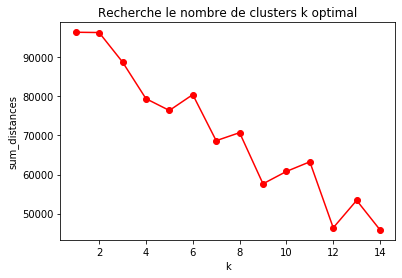

In [124]:
# Search for the optimal hyperparameter k
sum_distances = []
K = range(1, 15)
for k in K:
    km = KModes(n_clusters=k, init='random')
    km.fit_predict(OH_cols)
    sum_distances.append(km.cost_)
kk = sum_distances.index(min(sum_distances)) + 1

print("le nombre de clusters optimal est : {}".format(kk))

plt.plot(K, sum_distances, 'ro-')
plt.xlabel('k')
plt.ylabel('sum_distances')
plt.title('Recherche le nombre de clusters k optimal')

plt.show()

In [125]:
# Group related categories
km = KModes(n_clusters=kk, init='random', n_init=kk+1)
km.fit_predict(OH_cols)
kmodes = km.cluster_centroids_
shape = kmodes.shape
for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("cluster sans catégorie")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in OH_cols.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
cluster sans catégorie

cluster 1: 
toys

cluster 2: 
perfumery

cluster 3: 
housewares

cluster 4: 
bed_bath_table

cluster 5: 
furniture_decor

cluster 6: 
sports_leisure

cluster 7: 
pet_shop
watches_gifts

cluster 8: 
auto

cluster 9: 
cluster sans catégorie

cluster 10: 
costruction_tools_tools

cluster 11: 
cluster sans catégorie

cluster 12: 
health_beauty

cluster 13: 
electronics


<BarContainer object of 14 artists>

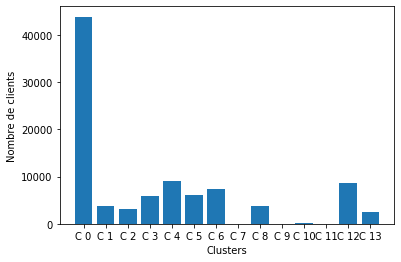

In [126]:
x = []
y = []
for i in range(0, kk):
    x.append("C " + str(i))
    y.append(np.sum(km.labels_ == i))

plt.xlabel('Clusters')
plt.ylabel('Nombre de clients')
plt.bar(x, y)

```
Fusion feature : product_category_name, R, F, M
```

In [0]:
X = pd.concat([rfmTable, OH_cols], axis=1)

In [128]:
X.shape

(94096, 76)

```
Add number of products bought
```

In [129]:
X.shape

(94096, 76)

In [0]:
nb_prod_by_cus = donnees[["customer_unique_id", "order_id"]].\
    groupby('customer_unique_id').count()

nb_prod_by_cus = nb_prod_by_cus.rename(columns={"order_id": "nb_prod_by_cus"})

In [0]:
X = pd.concat([X, nb_prod_by_cus], axis=1)

In [132]:
X.head()

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,small_appliances_home_oven_and_coffee,books_general_interest,home_appliances,costruction_tools_tools,signaling_and_security,costruction_tools_garden,construction_tools_construction,music,fashion_shoes,industry_commerce_and_business,fashion_underwear_beach,dvds_blu_ray,construction_tools_safety,fixed_telephony,tablets_printing_image,market_place,christmas_supplies,agro_industry_and_commerce,furniture_bedroom,books_technical,computers,books_imported,home_comfort_2,party_supplies,portateis_cozinha_e_preparadores_de_alimentos,pc_gamer,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0000f46a3911fa3c0805444483337064,541,1,69.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
0004aac84e0df4da2b147fca70cf8255,292,1,180.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


```
Add mean score
```

In [0]:
mean_score = donnees[['customer_unique_id', 'review_score']].\
    groupby('customer_unique_id').mean()

mean_score = mean_score.rename(columns={"review_score": "mean_score"})

In [134]:
mean_score

,mean_score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
0000f46a3911fa3c0805444483337064,3.0
0000f6ccb0745a6a4b88665a16c9f078,4.0
0004aac84e0df4da2b147fca70cf8255,5.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5.0
fffea47cd6d3cc0a88bd621562a9d061,4.0
ffff371b4d645b6ecea244b27531430a,5.0


In [0]:
X = pd.concat([X, mean_score], axis=1)

In [136]:
X.head()

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,small_appliances_home_oven_and_coffee,books_general_interest,home_appliances,costruction_tools_tools,signaling_and_security,costruction_tools_garden,construction_tools_construction,music,fashion_shoes,industry_commerce_and_business,fashion_underwear_beach,dvds_blu_ray,construction_tools_safety,fixed_telephony,tablets_printing_image,market_place,christmas_supplies,agro_industry_and_commerce,furniture_bedroom,books_technical,computers,books_imported,home_comfort_2,party_supplies,portateis_cozinha_e_preparadores_de_alimentos,pc_gamer,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
0000f46a3911fa3c0805444483337064,541,1,69.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
0004aac84e0df4da2b147fca70cf8255,292,1,180.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5.0


```
Add One Hot state
```

In [0]:
grouped = donnees[['customer_unique_id', 'customer_state']].\
    groupby('customer_unique_id')

In [0]:
state_cus = {}
for name, group in grouped:
    state_cus[name] = list(set(group["customer_state"].values))

In [139]:
state_cus

{'0000366f3b9a7992bf8c76cfdf3221e2': ['SP'],
 '0000b849f77a49e4a4ce2b2a4ca5be3f': ['SP'],
 '0000f46a3911fa3c0805444483337064': ['SC'],
 '0000f6ccb0745a6a4b88665a16c9f078': ['PA'],
 '0004aac84e0df4da2b147fca70cf8255': ['SP'],
 '0004bd2a26a76fe21f786e4fbd80607f': ['SP'],
 '00050ab1314c0e55a6ca13cf7181fecf': ['SP'],
 '00053a61a98854899e70ed204dd4bafe': ['PR'],
 '0005e1862207bf6ccc02e4228effd9a0': ['RJ'],
 '0005ef4cd20d2893f0d9fbd94d3c0d97': ['MA'],
 '0006fdc98a402fceb4eb0ee528f6a8d4': ['ES'],
 '00082cbe03e478190aadbea78542e933': ['SP'],
 '00090324bbad0e9342388303bb71ba0a': ['SP'],
 '000949456b182f53c18b68d6babc79c1': ['SP'],
 '000a5ad9c4601d2bbdd9ed765d5213b3': ['RS'],
 '000bfa1d2f1a41876493be685390d6d3': ['SP'],
 '000c8bdb58a29e7115cfc257230fb21b': ['MG'],
 '000d460961d6dbfa3ec6c9f5805769e1': ['SP'],
 '000de6019bb59f34c099a907c151d855': ['SP'],
 '000e309254ab1fc5ba99dd469d36bdb4': ['GO'],
 '000ec5bff359e1c0ad76a81a45cb598f': ['SP'],
 '000ed48ceeb6f4bf8ad021a10a3c7b43': ['SP'],
 '000fbf04

In [0]:
colstate_indice = {}
i = 0
for state in donnees["customer_state"].unique():
    colstate_indice[state] = i
    i += 1

In [141]:
OH_cols = pd.DataFrame(columns=list(donnees["customer_state"].unique()))
OH_cols

,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC


In [0]:
for k, v in state_cus.items():
    row = [0]*OH_cols.shape[1]
    for state in v:
        row[colstate_indice[state]] = 1
    OH_cols.loc[k] = row

In [143]:
OH_cols.head()

,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC
0000366f3b9a7992bf8c76cfdf3221e2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f46a3911fa3c0805444483337064,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X = pd.concat([X, OH_cols], axis=1)

```
Add density population of state
```

In [0]:
cus_state_nunique = dict(donnees["customer_state"].value_counts())

In [0]:
col_state_count = []
for k, v in state_cus.items():
    col_state_count.append(cus_state_nunique[v[0]])

In [0]:
X["nb_cus_by_state"] = col_state_count

In [148]:
X.head()

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,...,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC,nb_cus_by_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47060
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47060
0000f46a3911fa3c0805444483337064,541,1,69.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,3.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4128
0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,4.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1069
0004aac84e0df4da2b147fca70cf8255,292,1,180.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,47060


In [0]:
X.to_csv("OC4.csv", sep=',', index=True)

In [0]:
X = pd.read_csv("OC4.csv")

In [17]:
X

,customer_unique_id,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,...,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC,nb_cus_by_state
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,1.0,129.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1.0,18.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
2,0000f46a3911fa3c0805444483337064,541.0,1.0,69.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4128.0
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,1.0,25.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1069.0
4,0004aac84e0df4da2b147fca70cf8255,292.0,1.0,180.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94091,fffcf5a5ff07b0908bd4e2dbc735a684,451.0,1.0,1570.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1797.0
94092,fffea47cd6d3cc0a88bd621562a9d061,266.0,1.0,64.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3759.0
94093,ffff371b4d645b6ecea244b27531430a,572.0,1.0,89.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [0]:
X = X.set_index("customer_unique_id")

In [19]:
X

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,...,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC,nb_cus_by_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115.0,1.0,129.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1.0,18.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
0000f46a3911fa3c0805444483337064,541.0,1.0,69.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4128.0
0000f6ccb0745a6a4b88665a16c9f078,325.0,1.0,25.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1069.0
0004aac84e0df4da2b147fca70cf8255,292.0,1.0,180.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,451.0,1.0,1570.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1797.0
fffea47cd6d3cc0a88bd621562a9d061,266.0,1.0,64.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3759.0
ffff371b4d645b6ecea244b27531430a,572.0,1.0,89.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [0]:
# Machine Learning Algorithms

In [0]:
for f in X.columns:
    X[f] = X[f].astype(float)

In [0]:
X.loc['ff22e30958c13ffe219db7d711e8f564', 'recency'] = 0

In [22]:
X[X['recency'] < 0]

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,...,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC,nb_cus_by_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [0]:
X["monetary_value"] = np.log1p(X["monetary_value"])

In [24]:
X

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,...,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC,nb_cus_by_state
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115.0,1.0,4.874434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1.0,2.990720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
0000f46a3911fa3c0805444483337064,541.0,1.0,4.248495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4128.0
0000f6ccb0745a6a4b88665a16c9f078,325.0,1.0,3.295466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1069.0
0004aac84e0df4da2b147fca70cf8255,292.0,1.0,5.198497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47060.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,451.0,1.0,7.359468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1797.0
fffea47cd6d3cc0a88bd621562a9d061,266.0,1.0,4.187987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3759.0
ffff371b4d645b6ecea244b27531430a,572.0,1.0,4.509760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

In [0]:
# To scale the features
# X = segmented_rfm[["recency", "frequency", "monetary_value"]]

X_scale = preprocessing.StandardScaler().fit_transform(X)

In [0]:
X_scale = pd.DataFrame(X_scale, index=list(X.index), columns=X.columns)

In [27]:
X_scale.head()

,recency,frequency,monetary_value,office_furniture,housewares,home_confort,sports_leisure,computers_accessories,toys,furniture_decor,art,bed_bath_table,auto,air_conditioning,telephony,health_beauty,garden_tools,pet_shop,food,baby,home_construction,watches_gifts,cool_stuff,furniture_living_room,kitchen_dining_laundry_garden_furniture,perfumery,stationery,fashio_female_clothing,consoles_games,construction_tools_lights,audio,food_drink,drinks,fashion_bags_accessories,luggage_accessories,musical_instruments,electronics,home_appliances_2,fashion_male_clothing,small_appliances,...,furniture_mattress_and_upholstery,fashion_sport,la_cuisine,flowers,diapers_and_hygiene,cine_photo,fashion_childrens_clothes,cds_dvds_musicals,arts_and_craftmanship,security_and_services,nb_prod_by_cus,mean_score,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC,nb_cus_by_state
0000366f3b9a7992bf8c76cfdf3221e2,-0.827604,-0.161146,0.412801,-0.116688,-0.256791,-0.06501,-0.294571,-0.273686,-0.206378,-0.268194,-0.046383,3.048026,-0.206602,-0.051717,-0.214827,-0.318739,-0.196203,-0.135196,-0.068932,-0.176988,-0.072277,-0.250286,-0.199797,-0.066558,-0.051302,-0.185311,-0.158148,-0.020363,-0.106638,-0.050989,-0.061015,-0.048958,-0.055793,-0.139572,-0.105098,-0.081706,-0.166561,-0.049393,-0.034211,-0.081837,...,-0.0201,-0.016942,-0.011755,-0.017558,-0.016625,-0.026292,-0.009221,-0.011294,-0.014941,-0.00461,-0.287511,0.681409,1.176892,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243,1.151908
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.808015,-0.161146,-1.617228,-0.116688,-0.256791,-0.06501,-0.294571,-0.273686,-0.206378,-0.268194,-0.046383,-0.328081,-0.206602,-0.051717,-0.214827,3.137364,-0.196203,-0.135196,-0.068932,-0.176988,-0.072277,-0.250286,-0.199797,-0.066558,-0.051302,-0.185311,-0.158148,-0.020363,-0.106638,-0.050989,-0.061015,-0.048958,-0.055793,-0.139572,-0.105098,-0.081706,-0.166561,-0.049393,-0.034211,-0.081837,...,-0.0201,-0.016942,-0.011755,-0.017558,-0.016625,-0.026292,-0.009221,-0.011294,-0.014941,-0.00461,-0.287511,-0.066559,1.176892,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243,1.151908
0000f46a3911fa3c0805444483337064,1.954092,-0.161146,-0.261757,-0.116688,-0.256791,-0.06501,-0.294571,-0.273686,-0.206378,-0.268194,-0.046383,-0.328081,-0.206602,-0.051717,-0.214827,-0.318739,-0.196203,-0.135196,-0.068932,-0.176988,-0.072277,-0.250286,-0.199797,-0.066558,-0.051302,-0.185311,6.323178,-0.020363,-0.106638,-0.050989,-0.061015,-0.048958,-0.055793,-0.139572,-0.105098,-0.081706,-0.166561,-0.049393,-0.034211,-0.081837,...,-0.0201,-0.016942,-0.011755,-0.017558,-0.016625,-0.026292,-0.009221,-0.011294,-0.014941,-0.00461,-0.287511,-0.814527,-0.849695,-0.099694,-0.241119,-0.38451,5.119678,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243,-1.016975
0000f6ccb0745a6a4b88665a16c9f078,0.543654,-0.161146,-1.288811,-0.116688,-0.256791,-0.06501,-0.294571,-0.273686,-0.206378,-0.268194,-0.046383,-0.328081,-0.206602,-0.051717,4.654919,-0.318739,-0.196203,-0.135196,-0.068932,-0.176988,-0.072277,-0.250286,-0.199797,-0.066558,-0.051302,-0.185311,-0.158148,-0.020363,-0.106638,-0.050989,-0.061015,-0.048958,-0.055793,-0.139572,-0.105098,-0.081706,-0.166561,-0.049393,-0.034211,-0.081837,...,-0.0201,-0.016942,-0.011755,-0.017558,-0.016625,-0.026292,-0.009221,-0.011294,-0.014941,-0.00461,-0.287511,-0.066559,-0.849695,10.030730,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.1

# Dimensionality Reduction

In [0]:
pca = PCA().fit(X_scale)

In [157]:
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [158]:
components_total = len(pca.explained_variance_ratio_)
components_total

106

In [0]:
components = np.arange(components_total)

Text(0.5, 1.0, 'Cumulative Explained Variance vs No. of Principal Components')

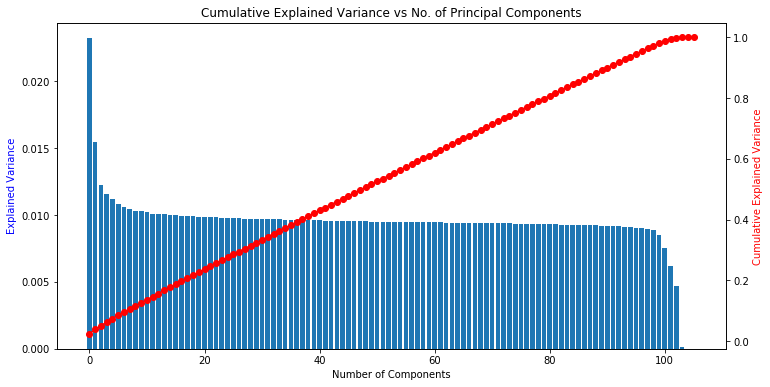

In [160]:
# Investigate the variance accounted for by each principal component.
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(components, pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx()
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red", marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")

plt.title("Cumulative Explained Variance vs No. of Principal Components")

In [0]:
pca_50 = PCA(n_components=50).fit(X_scale)

In [162]:
pca_50.explained_variance_ratio_.sum()

0.5085436810227998

# Interpret Principal Components

In [0]:
def get_cpn_feat_wgt(pca, x_scale, cpn_num):
    '''
    Give feature weight of n-th component of pca object
    '''
    weights = pd.DataFrame(np.round(pca.components_, 4),
                           columns=x_scale.columns)
    weight_n = weights.iloc[cpn_num-1, :].sort_values()
    weight_n = weight_n.to_frame()
    weight_n.reset_index(level=0, inplace=True)
    weight_n.columns = ['colname', 'weight']
    return weight_n

In [0]:
def get_top_feature(cpn_feat_wgt, n=5):
    tail_n = cpn_feat_wgt.head(n).reset_index(drop=True)
    head_n = cpn_feat_wgt.tail(n).\
        sort_values(by='weight', ascending=False).reset_index(drop=True)
    top_n = pd.concat([head_n, tail_n], axis=1)
    top_n.columns = ['top_pos_col', 'top_pos_col_wgt',
                     'top_neg_col', 'top_neg_col_wgt']
    return top_n

In [165]:
cpn_wgt_1st = get_cpn_feat_wgt(pca_50, X_scale, 1)
get_top_feature(cpn_wgt_1st, 5).style.\
    bar(subset=['top_pos_col_wgt', 'top_neg_col_wgt'],
        align='mid', color=['#d65f5f', '#5fba7d'])

,top_pos_col,top_pos_col_wgt,top_neg_col,top_neg_col_wgt
0,RJ,0.1573,nb_cus_by_state,-0.6322
1,MG,0.1532,SP,-0.6287
2,RS,0.1357,mean_score,-0.0628
3,PR,0.1306,bed_bath_table,-0.0424
4,SC,0.1181,housewares,-0.0385


In [0]:
X_pca_50 = pca_50.transform(X_scale)

In [167]:
X_pca_50

array([[-2.04130965, -0.04099726, -0.55593844, ..., -0.13538587,
        -0.01659452,  0.02793056],
       [-1.89576673, -0.60270612,  0.57139705, ..., -0.04685832,
         0.03668825,  0.05002186],
       [ 1.62047188, -0.74669966, -0.76882235, ..., -0.14170908,
         0.4113997 ,  0.23744784],
       ...,
       [ 1.73334832, -0.61526163,  0.41670196, ..., -0.1050245 ,
        -0.02681991, -0.64239089],
       [ 1.56501645, -0.57197634,  1.58614719, ..., -0.18397635,
        -0.78537888, -1.14039928],
       [ 1.40455191, -0.89755089, -0.46926858, ..., -0.20990095,
         0.45339242, -0.13224937]])

In [78]:
list(X.columns)

['recency',
 'frequency',
 'monetary_value',
 'office_furniture',
 'housewares',
 'home_confort',
 'sports_leisure',
 'computers_accessories',
 'toys',
 'furniture_decor',
 'art',
 'bed_bath_table',
 'auto',
 'air_conditioning',
 'telephony',
 'health_beauty',
 'garden_tools',
 'pet_shop',
 'food',
 'baby',
 'home_construction',
 'watches_gifts',
 'cool_stuff',
 'furniture_living_room',
 'kitchen_dining_laundry_garden_furniture',
 'perfumery',
 'stationery',
 'fashio_female_clothing',
 'consoles_games',
 'construction_tools_lights',
 'audio',
 'food_drink',
 'drinks',
 'fashion_bags_accessories',
 'luggage_accessories',
 'musical_instruments',
 'electronics',
 'home_appliances_2',
 'fashion_male_clothing',
 'small_appliances',
 'small_appliances_home_oven_and_coffee',
 'books_general_interest',
 'home_appliances',
 'costruction_tools_tools',
 'signaling_and_security',
 'costruction_tools_garden',
 'construction_tools_construction',
 'music',
 'fashion_shoes',
 'industry_commerce_and_bu

In [0]:
X_red = pd.concat([X_scale[["recency",	"frequency",	"monetary_value", 'nb_prod_by_cus', 'nb_cus_by_state']], X_scale.loc[:, 'SP':'AC']], axis=1)


In [29]:
X_red

,recency,frequency,monetary_value,nb_prod_by_cus,nb_cus_by_state,SP,PA,RS,RJ,SC,MG,MT,BA,ES,PR,MS,CE,MA,RN,TO,RR,PB,DF,GO,PE,PI,RO,AL,SE,AM,AP,AC
0000366f3b9a7992bf8c76cfdf3221e2,-0.827604,-0.161146,0.412801,-0.287511,1.151908,1.176892,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.808015,-0.161146,-1.617228,-0.287511,1.151908,1.176892,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
0000f46a3911fa3c0805444483337064,1.954092,-0.161146,-0.261757,-0.287511,-1.016975,-0.849695,-0.099694,-0.241119,-0.38451,5.119678,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
0000f6ccb0745a6a4b88665a16c9f078,0.543654,-0.161146,-1.288811,-0.287511,-1.171513,-0.849695,10.030730,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
0004aac84e0df4da2b147fca70cf8255,0.328171,-0.161146,0.762035,-0.287511,1.151908,1.176892,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1.366409,-0.161146,3.090857,1.249627,-1.134735,-0.849695,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,7.632458,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
fffea47cd6d3cc0a88bd621562a9d061,0.158396,-0.161146,-0.326965,-0.287511,-1.035617,-0.849695,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,5.315036,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
ffff371b4d645b6ecea244b27531430a,2.156515,-0.161146,0.019801,-0.287511,-1.172675,-0.849695,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,10.406098,-0.188145,-0.145091,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243
ffff5962728ec6157033ef9805bacc48,-0.775366,-0.161146,0.282571,-0.287511,-1.111799,-0.849695,-0.099694,-0.241119,-0.38451,-0.195325,-0.364211,-0.096097,-0.188145,6.892249,-0.231135,-0.085255,-0.117852,-0.087256,-0.070472,-0.053444,-0.021382,-0.073602,-0.148565,-0.143402,-0.131019,-0.071154,-0.049608,-0.064927,-0.059863,-0.038876,-0.026694,-0.028243


5
                       recency frequency monetary_value
                          mean      mean           mean
cluster_appartenance                                   
0                     0.085811  0.008275       0.026291
1                    -0.070536  0.004261      -0.081678
2                     0.052222 -0.005335       0.077005
3                     0.032800 -0.003048       0.025140
4                     0.035811  0.009091      -0.002125

6
                       recency frequency monetary_value
                          mean      mean           mean
cluster_appartenance                                   
0                    -0.070536  0.004261      -0.081678
1                     0.050764  0.016744       0.195487
2                     0.015838 -0.010442       0.151306
3                     0.052938 -0.004732       0.066637
4                     0.085811  0.008275       0.026291
5                     0.032926 -0.003468       0.025127

7
                       recency frequency

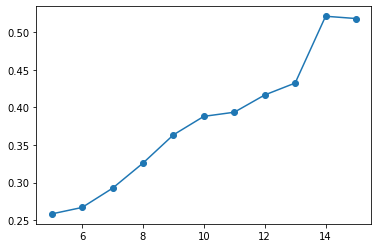

In [28]:
# Search for the optimal hyperparameter k
silhouettes = []
sum_mean_square_distances = []
interval = range(5, 16)
for num_clusters in interval:
    print(num_clusters)
    cls = KMeans(n_clusters=num_clusters)
    cls.fit(X_red)
    X1 = X_red.copy()
    X1["cluster_appartenance"] = cls.labels_
    stats1 = X1.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]].agg([np.mean])
    print(stats1)
    print("")
    score = metrics.silhouette_score(X_red, cls.labels_)
    silhouettes.append(score)
n_clusters = silhouettes.index(max(silhouettes)) + min(interval)

print("Le nombre de clusters optimal est : {}".format(n_clusters))
print("La valeur de la silhouette est de : {}".format(max(silhouettes)))

plt.plot(interval, silhouettes, marker="o")

Variance expliquée par les deux premières composantes : 0.126
Pour n_clusters = 14 , Le score de la silhouette moyenne est : 0.4362573911195213


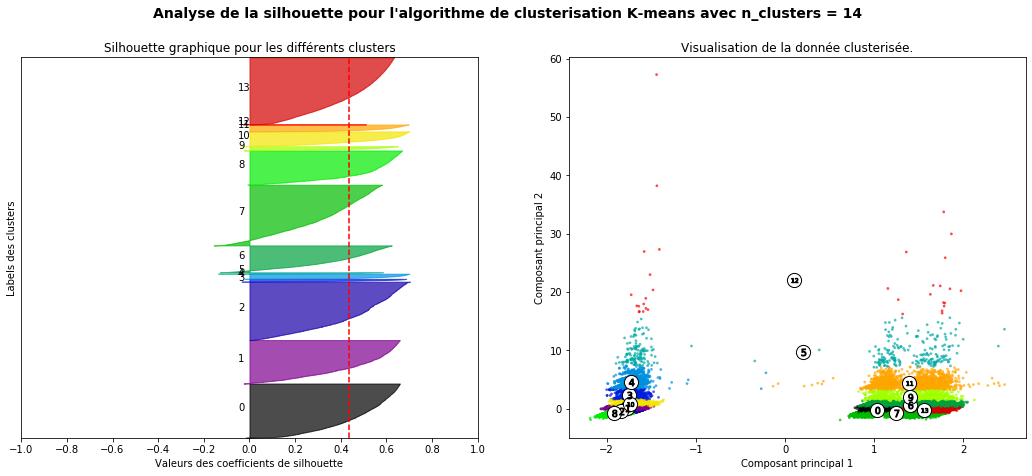

In [81]:
pca = PCA(n_components=2).fit(X_red)
reduced_data = pca.transform(X_red)
print("Variance expliquée par les deux premières composantes : %.3f" \
      % pca.explained_variance_ratio_.cumsum()[1])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# Plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels = clusterer.fit_predict(reduced_data)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(reduced_data, cluster_labels)
print("Pour n_clusters =", n_clusters, ", Le score de la silhouette moyenne est :",
      silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(reduced_data, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # luster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette graphique pour les différents clusters")
ax1.set_xlabel("Valeurs des coefficients de silhouette")
ax1.set_ylabel("Labels des clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white",
            alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualisation de la donnée clusterisée.")
    ax2.set_xlabel("Composant principal 1")
    ax2.set_ylabel("Composant principal 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means"
                  " avec n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

In [0]:
n_clusters = 14

In [0]:
clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels = clusterer.fit_predict(X_red)

In [32]:
X1 = X_red.copy()
X1["cluster_appartenance"] = cluster_labels
stats1 = X1.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]]. \
            agg([np.mean])
st1 = stats1.copy()
st1["size"] = X1.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st1

,recency,frequency,monetary_value,size
,mean,mean,mean,
cluster_appartenance,,,,
0,0.034168,-0.054515,0.057126,3187.0
1,0.027443,0.422556,1.157287,861.0
2,0.076542,-0.159587,0.149985,6141.0
3,-0.124500,5.195598,0.853614,2551.0
4,0.050764,0.016744,0.195487,861.0
5,-0.018966,-0.073756,-0.006444,4053.0
6,0.066098,-0.161146,0.018985,11589.0
7,0.035228,-0.161146,-0.011044,10600.0


In [0]:
customer_segment_ = pd.DataFrame()
segment_ = ["Best Customers", "Loyal Customers", "Promissing", "Big Spenders",
            "Almost Lost", "Lost Customers", "Lost Cheap Customers"
           ]
description_ = ["Les clients qui ont acheté le plus récemment, le plus souvent \
                et qui dépensent le plus.",
                "Les clients ayant acheté le plus récemment",
                "Des acheteurs récents, mais qui n'ont pas beaucoup dépensé",
                "Les clients qui dépensent le plus",
                "N'ont pas acheté depuis un certain temps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "N'ont pas acheté depuis longtemps, mais ont acheté fréquemment \
                et ont dépensé le plus.",
                "Dernier achat il y a longtemps, acheté peu et dépensé peu."
               ]
marketing_ = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
              "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
              "offrir des essais gratuits",
              "Commercialisez vos produits les plus chers.",
              "Offrez d'autres produits pertinents et des rabais spéciaux.",
              "Incitations à des prix agressifs",
              "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             ]
clusters = [11, 6, 3, 13, 0, 8, 2]
nb_cust_ = []
for i in clusters:
    nb_cust_.append(st1.loc[i, "size"].values[0])
customer_segment_["segment"] = segment_
customer_segment_["matching_cluster"] = clusters
customer_segment_["number of customers"] = nb_cust_
customer_segment_["segment description"] = description_
customer_segment_["marketing action"] = marketing_

In [37]:
st1.loc[0, "size"].values[0]

3187.0

In [39]:
customer_segment_

,segment,matching_cluster,number of customers,segment description,marketing action
0,Best Customers,11,10507.0,"Les clients qui ont acheté le plus récemment, ...","Pas d'incitation aux prix, Nouveaux produits e..."
1,Loyal Customers,6,11589.0,Les clients ayant acheté le plus récemment,Vendre des produits de plus grande valeur. Dem...
2,Promissing,3,2551.0,"Des acheteurs récents, mais qui n'ont pas beau...",offrir des essais gratuits
3,Big Spenders,13,4983.0,Les clients qui dépensent le plus,Commercialisez vos produits les plus chers.
4,Almost Lost,0,3187.0,"N'ont pas acheté depuis un certain temps, mais...",Offrez d'autres produits pertinents et des rab...
5,Lost Customers,8,926.0,"N'ont pas acheté depuis longtemps, mais ont ac...",Incitations à des prix agressifs
6,Lost Cheap Customers,2,6141.0,"Dernier achat il y a longtemps, acheté peu et ...",Ne passez pas trop de temps à essayer de vous ...


In [0]:
# K-means algorithm

In [0]:
vm = pd.DataFrame(stats1.values.T)
stand = preprocessing.StandardScaler().fit_transform(vm)
sns.set()
sns.lineplot(data=stand, hue="Clusters", markers=True)

In [0]:
stats1 = stats1.rename(index={0: "best customer", 1: "promissing",
                              2: "Lost customers", 3: "Hibernating"}
                      )
stats1

In [0]:
population_avg = XX[['recency', "frequency", "monetary_value"]].mean()
cluster_avg = X1[['recency', "frequency", "monetary_value", 'cluster_appartenance']].groupby(['cluster_appartenance']).mean()
relative_imp = cluster_avg / population_avg - 1
#relative_imp = relative_imp.rename(index={0: "best customer", 1: "promissing",
                                          #2: "Lost customers", 3: "Hibernating"}
                                  #)

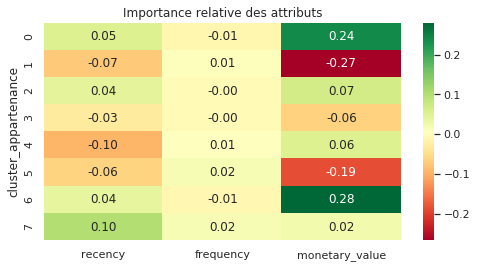

In [204]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

Pour n_clusters = 14 , Le score de la silhouette moyenne est : 0.33455202


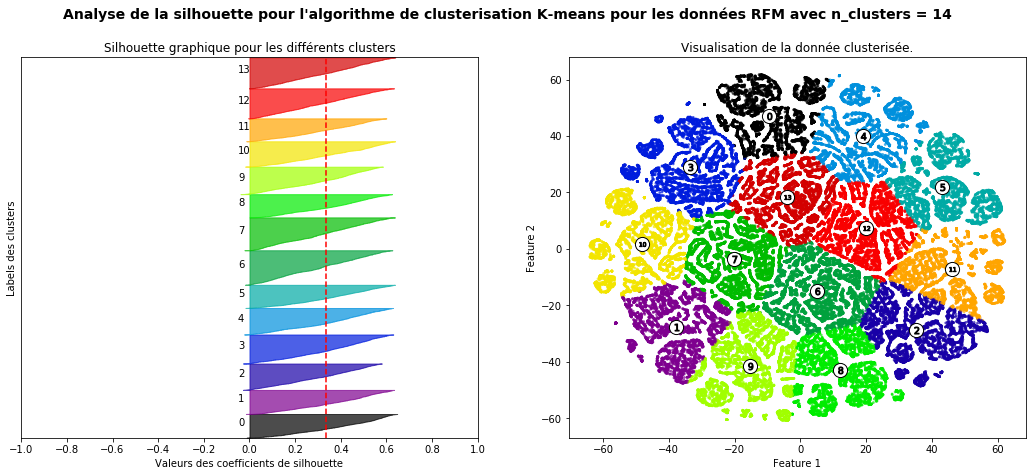

In [82]:
reduced_data = TSNE(n_components=2).fit_transform(X_red)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

clusterer = KMeans(n_clusters=n_clusters, init="random")
cluster_labels2 = clusterer.fit_predict(reduced_data)

# The silhouette_score gives the average value for all the samples.
silhouette_avg = metrics.silhouette_score(reduced_data, cluster_labels2)
print("Pour n_clusters =", n_clusters, ", Le score de la silhouette moyenne est :", silhouette_avg)
# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(reduced_data, cluster_labels2)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels2 == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
ax1.set_title("Silhouette graphique pour les différents clusters")
ax1.set_xlabel("Valeurs des coefficients de silhouette")
ax1.set_ylabel("Labels des clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels2.astype(float) / n_clusters)

ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualisation de la donnée clusterisée.")
    ax2.set_xlabel("Feature 1")
    ax2.set_ylabel("Feature 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means pour les données RFM "
                  "avec n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
plt.show()

In [0]:
X2 = X.copy()
X2["cluster_appartenance"] = cluster_labels2
stats2 = X2.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]]. \
            agg([np.mean])
st2 = stats2.copy()
st2["size"] = X2.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st2

In [0]:
vm = pd.DataFrame(stats2.values.T)
stand = preprocessing.StandardScaler().fit_transform(vm)
sns.set()
sns.lineplot(data=stand, markers=True)

In [0]:
stats2 = stats2.rename(index={0: "best customer", 1: "promissing",
                              2: "Lost customers", 3: "Hibernating"}
                      )
stats2

In [0]:
population_avg = X.mean()
cluster_avg = X2.groupby(['cluster_appartenance']).mean()
relative_imp2 = cluster_avg / population_avg - 1
relative_imp2 = relative_imp.rename(index={0: "best customer", 1: "promissing",
                                           2: "Lost customers", 3: "Hibernating"}
                                   )

In [0]:
plt.figure(figsize=(8, 4))
ax = sns.heatmap(data=relative_imp2, annot=True, fmt='.2f', cmap='RdYlGn')
ax.set_ylim(len(relative_imp), 0)
plt.title('Importance relative des attributs')
plt.show()

In [0]:
n_clusters_fix = 7
reduced_data = TSNE(n_components=2).fit_transform(X_scale)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(16, 7)

clusterer = KMeans(n_clusters=n_clusters_fix, init="random")
cluster_labels2 = clusterer.fit_predict(reduced_data)

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels2.astype(float) / n_clusters_fix)

ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0,
            alpha=0.7, c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax1.set_title("Visualisation de la donnée clusterisée.")
    ax1.set_xlabel("Feature 1")
    ax1.set_ylabel("Feature 2")

    plt.suptitle(("Analyse de la silhouette pour l'algorithme de clusterisation K-means pour les données RFM "
                  "avec n_clusters = %d" % n_clusters_fix
                 ), fontsize=14, fontweight='bold')
plt.show()

In [0]:
X3 = X.copy()
X3["cluster_appartenance"] = cluster_labels2
stats3 = X3.groupby('cluster_appartenance')[['recency', "frequency", "monetary_value"]].agg([np.mean])
st3 = stats3.copy()
st3["size"] = X3.groupby('cluster_appartenance')[['recency']].agg([np.size]) 
st3

In [0]:
X3.shape

In [0]:
dist = {}
for key, value in cus_id.items(): 
    d = []
    for c in range (0, 7):
        count = 0
        for j, row in X3.iterrows():
            if row["cluster_appartenance"] == c and j in value:
                count += 1
        d.append(count)
    dist[key] = d

In [0]:
dist

In [0]:
pd.DataFrame.from_dict(dist)

In [0]:
stats3 = stats3.rename(index={0: "Promissing", 1: "Big Spenders",
                              2: "Loyal Customers", 3: "Lost Cheap Customers",
                              4: "Best Customers", 5: "Lost Customers",6: "Almost Lost"
                             }
                      )

In [0]:
stats3

In [0]:
# DBSCAN Algorithm 

In [0]:
sns.set(style="ticks", color_codes=True)
eps = [0.5, 2]
neighs = [3, 5]
silhouettes = []
i = 0
score_max = 0
v_eps = 0
v_neigh = 0
for ep in eps:
    for n in neighs:
        db = DBSCAN(eps=ep, min_samples=n).fit(X_scale)
        score = metrics.silhouette_score(X_scale, db.labels_)
        silhouettes.append(score)
        if i == 0:
            v_eps = ep
            v_neigh = n
            score_max = score
            i += 1
        else:
            if score > score_max:
                v_eps = ep
                v_neigh = n
                score_max = score
print(v_eps)
print(v_neigh)
sns.lineplot(x=eps, y=silhouettes, hue=[3, 5, 3, 5], marker="o")

In [0]:
v_eps = 1

In [0]:
reduced_data = TSNE(n_components=2).fit_transform(X_scale)

db = DBSCAN(eps=v_eps, min_samples=10).fit(reduced_data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(reduced_data, labels))

# Black removed and is used for noise instead.
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12, 4)
colors = cm.nipy_spectral(labels.astype(float) / n_clusters_)
ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')
plt.show()

In [0]:
# Agglomerative clustering

In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [0]:
# Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X[:1000])
plt.title('Hierarchical Clustering Dendrogram')

# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Nombre de points dans le noeud (ou index de points si aucune parenthèse).")
plt.show()

In [0]:
clustering = AgglomerativeClustering(n_clusters = 4).fit(X_scale[:1000])
   clustering.labels_[:10]

In [0]:
len(set(['nama','guy', 'nama']))